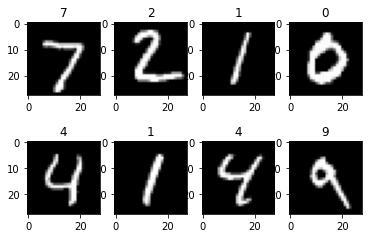

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from tqdm.notebook import tqdm
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from ADAM_TC import ADAM_TC
from levy.__init__ import fit_levy
import adaptive_algos as aa
import importlib
import pandas as pd
# Load MNIST Datasets
train_ds = torchvision.datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
test_ds = torchvision.datasets.MNIST(root='/data', train=False, transform=transforms.ToTensor(), download=True)

# Dataloader constructor
def get_minibatcher(dataset, batchsize, shuffle, seed):
    return torch.utils.data.DataLoader(dataset=dataset, batch_size=batchsize, shuffle=shuffle, pin_memory=True)
    # For data loading, passing pin_memory=True to a DataLoader will automatically put the fetched data Tensors 
    # in pinned memory, and thus enables faster data transfer to CUDA-enabled GPUs.

# Dataset examples
test_dl = get_minibatcher(test_ds, 10, False, 0)
examples = iter(test_dl)
example_images, example_targets = examples.next()

for i in range(8):
    plt.subplot(2,4,i+1)
    plt.imshow(example_images[i][0], cmap='gray')
    plt.title(int(example_targets[i]))
plt.show()

In [54]:
len(train_ds), len(test_ds)

(60000, 10000)

In [41]:
# Define fully connected neural network with 1/2 hidden layers
# Input size = 784 (28 x 28 pixel images)
# Output size = 10 (digits 1-10)
# Expedite training by introducing heavy-tailed noise from the start, rather than waiting for it to emerge

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 200, bias=False)
        #self.fc1 = nn.Linear(28*28, 10, bias=False)
        #self.fc2 = nn.Linear(200, 50, bias=False)
        #self.fc3 = nn.Linear(50, 10, bias=False)
        self.fc3 = nn.Linear(200, 10, bias=False)
    
    def forward(self, X):
        X = torch.relu(self.fc1(X))
        #X = torch.relu(self.|fc2(X))
        X = self.fc3(X)

        return X

class FullyConnected(nn.Module):

    def __init__(self, input_dim=28*28 , width=50, depth=3, num_classes=10):
        super(FullyConnected, self).__init__()
        self.input_dim = input_dim 
        self.width = width
        self.depth = depth
        self.num_classes = num_classes
        
        layers = self.get_layers()

        self.fc = nn.Sequential(
            nn.Linear(self.input_dim, self.width, bias=False),
            nn.ReLU(inplace=True),
            *layers,
            nn.Linear(self.width, self.num_classes, bias=False),
        )

    def get_layers(self):
        layers = []
        for i in range(self.depth - 2):
            layers.append(nn.Linear(self.width, self.width, bias=False))
            layers.append(nn.ReLU())
        return layers

    def forward(self, x):
        x = x.view(x.size(0), self.input_dim)
        x = self.fc(x)
        return x
    
    def get_grads(self):
        res = []
        for p in self.parameters():
            if p.requires_grad:
                res.append(p.grad.view(-1))
        grad_flat = torch.cat(res)
        return grad_flat

def cyclic_loader(dataloader):
    while True:
        for data in dataloader:
            yield data

# Based on Simsekli 2019    
def eval(dataloader, model, criterion, opt, device, alpha_est_sig_bound):
    
    model.eval()
    grads = []
    batch_count = 0

    for batch in dataloader:
        batch_count += 1
        opt.zero_grad()
        X, y = batch[0].to(device), batch[1].to(device)
        output = model(X)
        loss = criterion(output, y)
        loss.backward()
        grad = model.get_grads()
        grads.append(grad)
    
    param_num = len(grads[0])
    grads = torch.cat(grads).view(-1, param_num)                                            # column for each param, row for each batch
    full_batch_grad = grads.sum(dim=0) / batch_count                                        # sum across batches (down the rows)
    gradient_noise = grads - full_batch_grad
    noise_norm = gradient_noise.norm(dim=1)                                                 # compute norm of gradient vector for each batch(across columns)
    
    # Over parameterised --> many gradients stay 0, so we underestimate alpha --> clean these parameters.
    s = torch.sum(torch.abs(gradient_noise), dim=0)
    p = s/s.max()
    gradient_noise_cleaned = gradient_noise[:, p >= alpha_est_sig_bound].detach().cpu()
    #print('Used {} number of params to estimate alpha'.format(sum(p >= alpha_est_sig_bound)))
    batch_count = gradient_noise_cleaned.shape[0]
    param_num = gradient_noise_cleaned.shape[1]

    N = param_num * batch_count
    # for i in range(1 + int(np.sqrt(N)), 1, -1):
    #     print(i)
    #     if N % i == 0:
    #         m = i
    #         break
    gradient_noise_cleaned_np = np.ravel(gradient_noise_cleaned.numpy())
    del gradient_noise_cleaned
    mu_est = gradient_noise_cleaned_np.mean()
    print('fit', gradient_noise_cleaned_np.shape)
    alpha = fit_levy(gradient_noise_cleaned_np, beta=0.0, mu=mu_est)[0].get()[0]
    print('fit done')
    #alpha = alpha_estimator(m, gradient_noise_cleaned.view(-1, 1))
    
    del full_batch_grad
    del gradient_noise
    del grads
    del p, s

    return noise_norm.cpu(), alpha

# Corollary 2.4 in Mohammadi 2014
# def alpha_estimator(m, X):
#     N = len(X)
#     n = int(N/m)
#     Y = torch.sum(X.view(n,m,-1,), 1)
#     eps = np.spacing(1)
#     Y_log_norm = torch.log(torch.linalg.norm(Y, dim=1) + eps).mean()
#     X_log_norm = torch.log(torch.linalg.norm(X, dim=1) + eps).mean()
#     #Y_log_norm = torch.log(Y.abs() + eps).mean()
#     #X_log_norm = torch.log(X.abs() + eps).mean()
#     diff = (Y_log_norm - X_log_norm) / np.log(m)
#     return (1 / diff).item()

In [3]:
# Get fullbatch
# train_dl_fullbatch = get_minibatcher(train_ds, len(train_ds), False)
# for batch in train_dl_fullbatch:
#     print('Check full batch --- should only print once.')
#     full_batchX = batch[0].to(device)
#     full_batchy = batch[1].to(device)

# Define training procedure

def train_model(model, opt, device, criterion, alpha_est_sig_bound,
                train_cdl, train_dl_eval, train_loss, iteration_number, 
                eval_freq, noise_norms, alphas):
    batch = next(train_cdl)
    model.train()
    opt.zero_grad()
    images = batch[0].to(device)
    label = batch[1].to(device)
    output = model(images)
    loss = criterion(output, label)
    loss.backward()
    opt.step()
    train_loss.append(loss.item())
    
    if not iteration_number % eval_freq:
        noise_norm, alpha = eval(train_dl_eval, model, criterion, opt, 
                                 device, alpha_est_sig_bound)
        noise_norms.append(noise_norm)
        alphas.append(alpha)

        # mini_batch_grads.append(model.get_grads())
        # # Wipe mini-batch gradients after SGD step, then compute full batch gradients
        # opt.zero_grad()
        # full_batch_output = model(full_batchX)
        # loss_full = criterion(full_batch_output.squeeze(-1), full_batchy)
        # loss_full.backward()
        # full_batch_grads.append(model.get_grads())

def model_train_analysis(model, opt, criterion, device, seed,
                         train_ds, batch_size, max_iterations, eval_freq, 
                         alpha_est_sig_bound, plot=False):
    torch.manual_seed(seed)
    train_dl = get_minibatcher(train_ds, batch_size, True, seed)
    train_cdl = cyclic_loader(train_dl)
    train_dl_eval = get_minibatcher(train_ds, batch_size, False, seed)

    # LR-Scheduler
    milestone = int(max_iterations/3)
    scheduler = optim.lr_scheduler.MultiStepLR(opt, milestones=[milestone, 2*milestone],
                                               gamma=0.01
                )

    # Training
    noise_norms = []
    alphas = []
    train_loss = []

    if plot:
        for i in tqdm(range(max_iterations)):
            print(i, end=' ')
            train_model(model, opt, device, criterion, alpha_est_sig_bound,
                        train_cdl, train_dl_eval, train_loss, i, 
                        eval_freq, noise_norms, alphas)

    else:
        for i in tqdm(range(max_iterations)):
            train_model(model, device, criterion, alpha_est_sig_bound,
                        train_cdl, train_dl_eval, opt, train_loss, i, 
                        eval_freq, noise_norms, alphas)
                
            
    predlist = torch.zeros(0, dtype=torch.long).to(device)
    labellist = torch.zeros(0, dtype=torch.long).to(device)

    # Testing
    with torch.no_grad():
        for ims, labels in test_dl:
            ims = ims.reshape(-1, 28*28).to(device)
            labels = labels.to(device)
            outputs = model(ims).to(device)
            _, predicted = torch.max(outputs.data, 1)
            predlist = torch.cat([predlist, predicted.view(-1)])
            labellist = torch.cat([labellist, labels.view(-1)])

    # Model evaluation
    if plot:
        print(classification_report(np.asarray(labellist.cpu()), np.asarray(predlist.cpu()), digits=3))
        fig = px.line(train_loss)
        fig.show()
    acc = accuracy_score(np.asarray(labellist.cpu()), np.asarray(predlist.cpu()))

    del labellist
    del predlist

    return noise_norms, alphas, train_loss, acc

In [4]:
# Define parameters
importlib.reload(aa)
torch.cuda.empty_cache()
device = 'cuda'

lr = 0.1
batch_size = 32
max_iterations = 1000
eval_freq = 100
alpha_est_sig_bound = 0.5   
nn_list, alphas_list, train_loss_list, acc_list = [], [], [], []

# Specify problem
model = FullyConnected().to(device)
criterion = nn.CrossEntropyLoss()
opt = torch.optim.SGD(params=model.parameters(), lr=lr)

nns, alphas, train_loss, acc = model_train_analysis(model, opt, criterion, device, 69,
                                                    train_ds, batch_size, max_iterations, eval_freq,
                                                    alpha_est_sig_bound, plot=True)
# for seed in range(10):
#     gns, nns, alphas, train_loss, acc = model_train_analysis(42, train_ds, batch_size, max_iterations, eval_freq, alpha_est_sig_bound, plot=False)
#     gn_list.append(gns)
#     nn_list.append(nns)
#     alphas_list.append(alphas)
#     train_loss_list.append(train_loss)
#     acc_list.append(acc)

  0%|          | 0/1000 [00:00<?, ?it/s]

0 fit (88125,)


KeyboardInterrupt: 

In [5]:
acc

0.9134

In [6]:
noise_norms = nns
noise_norms_flat = [norm for noise_norm in noise_norms for norm in list(noise_norm)]
burnin = 60000//batch_size
print(len(noise_norms_flat), burnin)
px.histogram(noise_norms_flat[burnin:])
# Multimodal (second peak close to 0) if we include "burn-in"

60000 6000


In [7]:
px.line(x=eval_freq*np.arange(0,len(alphas)), y=alphas)

In [10]:
# For each gradient_noises entry
    #  Check across all batches, remove noise vector components that are always 0
gradient_noise_eg = gradient_noises[5]
s = torch.sum(torch.abs(gradient_noise_eg), dim=0)
p = s/s.max()
gradient_noise_eg_cleaned = gradient_noise_eg[:, p > 0.2]
noise_norm = gradient_noise_eg_cleaned.norm(dim=1)
batch_count = gradient_noise_eg_cleaned.shape[0]
param_num = gradient_noise_eg_cleaned.shape[1]

N = param_num * batch_count
for i in range(1+int(np.sqrt(N)), 1, -1):
    if N % i == 0:
        m = i
        break
print(gradient_noise.shape)
# Over parameterised --> many gradients stay 0, so we underestimate alpha?
alpha = alpha_estimator(m, gradient_noise_eg_cleaned.view(-1, 1))
print(alpha)

NameError: name 'gradient_noises' is not defined

In [11]:
s = torch.sum(torch.abs(gradient_noise_eg), dim=0)
p = s/s.max()
sum(p > 0.2)

NameError: name 'gradient_noise_eg' is not defined

In [ ]:
"""Code bank and notes"""

        # param in model.parameters() --> weights shape (output x input e.g. 200 x 28*28) then biases shape (output)
        # Setting bias=False in nn.Linear(...) gives only weight
        # one weight/bias pair for each network layer
        # for some reason - weight gradients always 0??? ---> ANS: no inputs to first layer, so ofc

        # Diagnostic code
        # for param in model.parameters():
        #     print(param.grad)
        #     print(param.grad.shape)
        #     print(param.shape)
        # print('epoch donnneeeee')
        # break

#     if not i % 5:
#         mini_batch_grads.append(model.get_grads())
#         # Wipe mini-batch gradients after SGD step, then compute full batch gradients
#         opt.zero_grad()
#         full_batch_output = model(full_batchX)
#         loss_full = criterion(full_batch_output.squeeze(-1), full_batchy)
#         loss_full.backward()
#         full_batch_grads.append(model.get_grads())

        # # Compute gradient noise
        # print(len(mini_batch_grads))
        # grad_noise_mags = []
        # for mb_grad, fb_grad in zip(mini_batch_grads, full_batch_grads):
        # grad_noise = mb_grad - fb_grad
        # grad_noise_mag = torch.linalg.norm(grad_noise.cpu())
        # grad_noise_mags.append(grad_noise_mag)
        # px.histogram(grad_noise_mags)

In [18]:
# Repeat for SGD_TC --------------------------------- (DUPLICATE OF ABOVE)
importlib.reload(aa)
device = 'cuda'
lr = 0.1
height = 1.0
width = 10

batch_size = 32
max_iterations = 1000
eval_freq = 100
alpha_est_sig_bound = 0.5
nn_list, alphas_list, train_loss_list, acc_list = [], [], [], []

# Specify problem
model = FullyConnected().to(device)
criterion = nn.CrossEntropyLoss()
scale_annealer = lambda progress: 1 - progress

opt_params={'lr': lr, 'height': height, 'width': width, 'n_epochs': max_iterations, 
            'scale_annealer': scale_annealer, 'device': device, 'adjust_dir': True}
opt = aa.SGD_TC(params=model.parameters(), **opt_params)

nns, alphas, train_loss, acc = model_train_analysis(model, opt, criterion, device, 69,
                                                    train_ds, batch_size, max_iterations, eval_freq,
                                                    alpha_est_sig_bound, plot=True)

  0%|          | 0/1000 [00:00<?, ?it/s]

0 fit (465000,)
fit done
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 

C:\Users\karls\AppData\Local\Temp/ipykernel_14816/3902134365.py:104: RuntimeWarning:

Mean of empty slice.

c:\Users\karls\anaconda3\envs\honours\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning:

invalid value encountered in true_divide



fit (0,)
fit done
101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 fit (0,)
fit done
201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 277 278 279 280 281 282 283 284 285 286 287 288 289 290 291 292 293 294 295 296 297 298 299 300 fit (0,)
fit done
301 302 303 304 305 306 307 308 309 310 311 312 313 314 315 316 317 318 319 320 321 322 323 324 325 326 327 328 329 330 331 332 333 334 335 336 33

c:\Users\karls\anaconda3\envs\honours\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\karls\anaconda3\envs\honours\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\karls\anaconda3\envs\honours\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [56]:
acc

0.5732

In [ ]:
noise_norms = nns
noise_norms_flat = [norm for noise_norm in noise_norms for norm in list(noise_norm)]
burnin = 60000//batch_size
print(len(noise_norms_flat), burnin)
px.histogram(noise_norms_flat[burnin:])
# Multimodal (second peak close to 0) if we include "burn-in"

60000 6000


In [ ]:
px.line(x=eval_freq*np.arange(0,len(alphas)), y=alphas)

In [ ]:
px.scatter(opt.alpha_record)

## Fast Training No Eval

In [6]:
def train_noeval(opter, opt_params, batch_size, max_iterations, device, single=False, seed=22):

    torch.manual_seed(seed)
    train_dl = get_minibatcher(train_ds, batch_size, True, seed)
    train_cdl = cyclic_loader(train_dl)
    train_dl_eval = get_minibatcher(train_ds, batch_size, False, seed)

    # Specify problem
    model = FullyConnected().to(device)
    criterion = nn.CrossEntropyLoss()

    opt = opter(params=model.parameters(), **opt_params)

    # Training
    train_loss = []
    pbar = tqdm(range(max_iterations)) if single else range(max_iterations)

    for i in pbar:
        batch = next(train_cdl)
        model.train()
        opt.zero_grad()
        images = batch[0].to(device)
        label = batch[1].to(device)
        output = model(images)
        loss = criterion(output, label)
        loss.backward()
        opt.step()
        train_loss.append(loss.item())
    
    if single:
        return model, opt, train_loss

    predlist = torch.zeros(0, dtype=torch.long).to(device)
    labellist = torch.zeros(0, dtype=torch.long).to(device)

    # Testing
    with torch.no_grad():
        for ims, labels in test_dl:
            ims = ims.reshape(-1, 28*28).to(device)
            labels = labels.to(device)
            outputs = model(ims).to(device)
            _, predicted = torch.max(outputs.data, 1)
            predlist = torch.cat([predlist, predicted.view(-1)])
            labellist = torch.cat([labellist, labels.view(-1)])
    acc = accuracy_score(np.asarray(labellist.cpu()), np.asarray(predlist.cpu()))

    return min(train_loss), acc

In [56]:
################################ SGD ###################################
importlib.reload(aa)
device = 'cuda'
batch_size = 32
max_iterations = 1000
lr = 0.1
opt_params={'lr': lr}

sgd_min_train_losses = []
sgd_accs = []
for i in tqdm(range(200)):
    sgd_min_train_loss, acc = train_noeval(torch.optim.SGD, opt_params, batch_size, max_iterations,
                                            device, single=False, seed=i)
    sgd_min_train_losses.append(sgd_min_train_loss)
    sgd_accs.append(acc)
sgd_min_train_losses = np.array(sgd_min_train_losses)
sgd_accs = np.array(sgd_accs)

  0%|          | 0/200 [00:00<?, ?it/s]

In [57]:
################################ SGD_TC ###################################
importlib.reload(aa)
device = 'cuda'
batch_size = 32
max_iterations = 1000
lr = 0.1
height = 1.0
width = 1
scale_annealer = lambda progress: (1 - progress)**2 * 0.01
#scale_annealer = lambda progress: (1-progress)

opt_params={'lr': lr, 'height': height, 'width': width, 'n_epochs': max_iterations, 
            'scale_annealer': scale_annealer, 'device': device, 'adjust_dir': True}

levy_min_train_losses = []
levy_accs = []
for i in tqdm(range(200)):
    levy_min_train_loss, acc = train_noeval(aa.SGD_TC, opt_params, batch_size, max_iterations,
                                            device, single=False, seed=i)
    levy_min_train_losses.append(levy_min_train_loss)
    levy_accs.append(acc)

levy_min_train_losses = np.array(levy_min_train_losses)
levy_accs = np.array(levy_accs)

  0%|          | 0/200 [00:00<?, ?it/s]

In [58]:
losses = pd.DataFrame({'SGD': sgd_min_train_losses, 
                       'Lévy': levy_min_train_losses})
accs = pd.DataFrame({'SGD': sgd_accs, 
                    'Lévy SGD ': levy_accs})

print(losses.mean(), losses.median())
print(accs.mean(), accs.median())

fig = px.histogram(accs, barmode="overlay")
fig.update_layout(
    height=800,
    width=1600,
    legend=dict(x=0.0,y=1, font=dict(size=20), title_text=''),
    xaxis_title='Test Accuracy',
    yaxis_title='Count',
    yaxis=dict(tickfont=dict(size=20), titlefont=dict(size=20)),
    xaxis=dict(tickfont=dict(size=20), titlefont=dict(size=20))
)
fig.show()


SGD     0.043254
Lévy    0.043082
dtype: float64 SGD     0.044022
Lévy    0.042986
dtype: float64
SGD          0.923512
Lévy SGD     0.924403
dtype: float64 SGD          0.9247
Lévy SGD     0.9258
dtype: float64


In [59]:
fig = px.histogram(losses, barmode="overlay")
fig.update_layout(
    height=800,
    width=1600,
    legend=dict(x=0.936,y=1, font=dict(size=20), title_text=''),
    xaxis_title='Training Cross Entropy Loss',
    yaxis_title='Count',
    yaxis=dict(tickfont=dict(size=20), titlefont=dict(size=20)),
    xaxis=dict(tickfont=dict(size=20), titlefont=dict(size=20))
)

In [42]:
# SGD Single
importlib.reload(aa)
device = 'cuda'
batch_size = 32
max_iterations = 1000
lr = 0.1

opt_params={'lr': lr}
model_sgd, opt_sgd, train_loss_sgd = train_noeval(torch.optim.SGD, opt_params, batch_size, 
                                           max_iterations, device, single=True)

predlist = torch.zeros(0, dtype=torch.long).to(device)
labellist = torch.zeros(0, dtype=torch.long).to(device)

# Testing
with torch.no_grad():
    for ims, labels in test_dl:
        ims = ims.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        outputs = model_sgd(ims).to(device)
        _, predicted = torch.max(outputs.data, 1)
        predlist = torch.cat([predlist, predicted.view(-1)])
        labellist = torch.cat([labellist, labels.view(-1)])

# Model evaluation
print(classification_report(np.asarray(labellist.cpu()), np.asarray(predlist.cpu()), digits=3))
fig = px.line(train_loss_sgd)
fig.update_layout(
    height=800,
    width=1600,
    showlegend=False,
    xaxis_title='Iteration Number',
    yaxis_title='Training Cross Entropy Loss',
    yaxis=dict(tickfont=dict(size=20), titlefont=dict(size=20)),
    xaxis=dict(tickfont=dict(size=20), titlefont=dict(size=20))
)
fig.show()
acc = accuracy_score(np.asarray(labellist.cpu()), np.asarray(predlist.cpu()))

  0%|          | 0/1000 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0      0.947     0.977     0.961       980
           1      0.977     0.975     0.976      1135
           2      0.872     0.942     0.905      1032
           3      0.882     0.930     0.905      1010
           4      0.906     0.898     0.902       982
           5      0.954     0.821     0.882       892
           6      0.988     0.866     0.923       958
           7      0.905     0.945     0.924      1028
           8      0.912     0.885     0.898       974
           9      0.878     0.939     0.908      1009

    accuracy                          0.920     10000
   macro avg      0.922     0.918     0.919     10000
weighted avg      0.922     0.920     0.920     10000



In [53]:
print(list(model_sgd.parameters())[0].numel())
print(list(model_sgd.parameters())[1].numel())
print(list(model_sgd.parameters())[2].numel())
print(model_sgd)

39200
2500
500
FullyConnected(
  (fc): Sequential(
    (0): Linear(in_features=784, out_features=50, bias=False)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=50, out_features=50, bias=False)
    (3): ReLU()
    (4): Linear(in_features=50, out_features=10, bias=False)
  )
)


In [45]:
# SGD_TC Single
importlib.reload(aa)
device = 'cuda'
batch_size = 32
max_iterations = 1000
lr = 0.1
height = 1.0
width = 1
scale_annealer = lambda progress: (1 - progress)**2 * 0.01
#scale_annealer = lambda progress: (1-progress)

opt_params={'lr': lr, 'height': height, 'width': width, 'n_epochs': max_iterations, 
            'scale_annealer': scale_annealer, 'device': device, 'adjust_dir': True}


model_levy, opt_levy, train_loss_levy = train_noeval(aa.SGD_TC, opt_params, batch_size, max_iterations,
                                                     device, single=True, seed=i)

predlist = torch.zeros(0, dtype=torch.long).to(device)
labellist = torch.zeros(0, dtype=torch.long).to(device)

# Testing
with torch.no_grad():
    for ims, labels in test_dl:
        ims = ims.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        outputs = model_levy(ims).to(device)
        _, predicted = torch.max(outputs.data, 1)
        predlist = torch.cat([predlist, predicted.view(-1)])
        labellist = torch.cat([labellist, labels.view(-1)])

# Model evaluation
print(classification_report(np.asarray(labellist.cpu()), np.asarray(predlist.cpu()), digits=3))
fig = px.line(train_loss_levy)
fig.update_layout(
    height=800,
    width=1600,
    showlegend=False,
    xaxis_title='Iteration Number',
    yaxis_title='Training Cross Entropy Loss',
    yaxis=dict(tickfont=dict(size=20), titlefont=dict(size=20)),
    xaxis=dict(tickfont=dict(size=20), titlefont=dict(size=20))
)
fig.show()
acc = accuracy_score(np.asarray(labellist.cpu()), np.asarray(predlist.cpu()))

  0%|          | 0/1000 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0      0.957     0.976     0.966       980
           1      0.965     0.982     0.973      1135
           2      0.940     0.909     0.924      1032
           3      0.843     0.946     0.891      1010
           4      0.899     0.954     0.926       982
           5      0.869     0.889     0.879       892
           6      0.944     0.947     0.945       958
           7      0.951     0.921     0.936      1028
           8      0.946     0.823     0.880       974
           9      0.928     0.877     0.902      1009

    accuracy                          0.923     10000
   macro avg      0.924     0.922     0.922     10000
weighted avg      0.925     0.923     0.923     10000



In [46]:
fig = px.line(opt_levy.alpha_record)
fig.show()